In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = dataloader.load()
dists, labels, words, sem_col_translator = data['dists'],data['labels'],data['words'],data['translator']

In [3]:
data = data['data']

In [4]:
# Create a dictionary of day:theta pairs (using the same variable name to save memory)
mi_arrays = {d.to_timestamp():_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))}

# Calculate Linkage
stats, mi_arrays = diachronic_linkage(mi_arrays)

# Flatten MI-matrices, parse to dict
mi_arrays_flat = {k:flatten_mi_array(v) for k,v in tqdm(mi_arrays.items())}

# Create a DF with linkage scores for every pair of topics, in all time periods
dfm = pd.DataFrame({k:v[2].to_numpy() for k,v in mi_arrays_flat.items()}).T
columns = [v for k,v in mi_arrays_flat.items()][-2]
columns[0] = columns[0].apply(lambda x: sem_col_translator[x])
columns[1] = columns[1].apply(lambda x: sem_col_translator[x])
columns = columns[[0,1]].astype(str).agg('-'.join,axis=1).tolist()
dfm.columns = columns

 70%|██████▉   | 1166/1667 [00:08<00:03, 140.41it/s]


KeyboardInterrupt: 

In [ ]:
# Import the calculated stats for the linkages
stats = pd.read_csv('results/linkage-stats-day.csv',sep='\t')
stats['date'] = pd.to_datetime(stats.date,infer_datetime_format=True)

In [ ]:
# Get correlations between the linkage mean, and individual diachronic linkage scores between two topics (in a specific time period)

def get_correlations_period(stats, dfm, min_year, max_year):
    
    # Get Mean Linkages for Time Period, AFA + ZSCORE
    lkg_trend = stats[(stats.date.dt.year >= min_year) & (stats.date.dt.year <= max_year)].mi_mu.to_numpy()
    lkg_trend = adaptive_filter(lkg_trend)
    lkg_trend = np.squeeze(np.asarray(lkg_trend))
    lkg_trend = zscore(lkg_trend)

    # Subset DF, transform to np
    dfm_ = dfm[(dfm.index.year >= min_year) & (dfm.index.year <= max_year)]
    dates = dfm_.index.tolist()
    dfm_arr = dfm_.to_numpy()

    # Loop
    cls_ = dfm.columns
    corr_df = []

    afa_z_arrs = {}

    for i in tqdm(range(dfm_arr.shape[1])):
        a = adaptive_filter(dfm_arr[:,i])
        a = np.squeeze(np.asarray(a))
        a = zscore(a)
        afa_z_arrs[cls_[i]] = a
        corr = np.correlate(lkg_trend,a)[0]
        corr_df.append((cls_[i],corr))
    corr_df = pd.DataFrame(corr_df,columns=['p','corr'])
    return corr_df, afa_z_arrs, lkg_trend, dates

In [ ]:
rdf = pd.DataFrame()

fig,ax = plt.subplots(1,1,figsize=(10,7))
results = dict()

for r in range(1945,1966,5):
    start_y, end_y = (r,r+5)
    results.update({r:{}})
    cdf, afa_z_arrs, lkg_trend, dates = get_correlations_period(stats,dfm,start_y,end_y)
    top = cdf.sort_values('corr',ascending=False).p.tolist()[:15]

    for t in top:
        ax.plot(dates,afa_z_arrs[t],alpha=.1,c='b')
        ax.plot(dates,lkg_trend,c='teal',lw=2)

    top_lbs = [(labels[int(i.split('-')[0])],labels[int(i.split('-')[1])]) for i in top]
    results[r]['top'] = top
    results[r]['toplabels'] = top_lbs
    results[r]['afa_z_arrs'] = afa_z_arrs
    results[r]['trendline'] = lkg_trend
    results[r]['dates'] = dates

 80%|████████  | 24578/30628 [02:06<00:40, 151.14it/s]

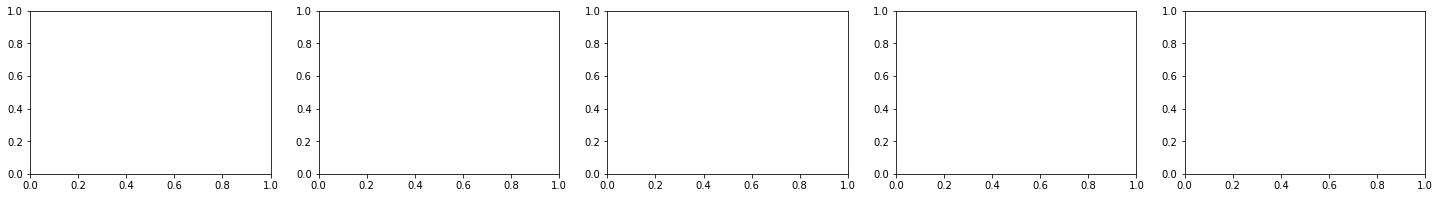

In [59]:
fig,ax = plt.subplots(1,5,figsize=(25,3))

c = 0
for y,v in results.items():

    ax[c].plot(v['dates'],v['trendline'])
    ax[c].set_title(f"{y}-{y+5}")

In [44]:
[(k,words[k]) for k,v in labels.items() if v == 'mining']

[(293,
  'mijnwerker mijnindustrie mijnbedrijf ondergronds mir mijnstreek limburgs kolenprocductie staatsmijnen bovengronds ondergronds mijnwerker limburgs mijnbedrijf limburgs mijnindustrie urig daf'),
 (396,
  'mijnindustrie kolenprocductie mijnbedrijf mijnwerker energiebeleid ondergronds huisbrandkool limburgs egks energiebron mijnstreek mir kool staatsmijn staatsmijnen'),
 (466,
  'staatsmijnen nvvorm rechtsvorm mijnraad rechtsvorm staatsmijnen afstoting daf aandeelhouder commissieverdam staatsbezit breedband gasmaatschappij hoogovens nv breedband breedband nv')]